# Overview of Image Captioning using Transformers

This project implements **Image Captioning** using **Transformer-based models** with TensorFlow version **1.9.1**. The goal is to generate descriptive captions for images by combining **Computer Vision** (to process images) and **Natural Language Processing** (to generate captions).

---

## Key Components of the Notebook:

1. **Environment Setup**:
   - The project is implemented using **TensorFlow 1.9.1** to leverage the specific features of this version.

2. **Data Loading and Preprocessing**:
   - Images are loaded, resized, and preprocessed for model input.
   - Captions are tokenized and prepared for training using sequence-based methods.

3. **Model Architecture**:
   - **Convolutional Neural Networks (CNNs)**, such as EfficientNet or ResNet, are used to extract image features.
   - A **Transformer-based Decoder** processes these image features to generate meaningful captions.
   - The architecture integrates both vision and language modalities efficiently.

4. **Training the Model**:
   - The model is trained using a **cross-entropy loss function** to minimize prediction errors.
   - Training includes optimizing both image feature extraction and sequence generation components.

5. **Evaluation**:
   - The model generates captions for unseen test images.
   - Performance metrics such as **BLEU score** or **CIDEr** are calculated to evaluate caption quality.

6. **Visualization**:
   - Sample test images are displayed alongside their generated captions for qualitative analysis.

---

## TensorFlow Version
- The notebook uses **TensorFlow 1.9.1**, ensuring compatibility with legacy code and APIs.

This project demonstrates how to implement **Image Captioning** by integrating **CNN-based feature extraction** and **Transformer-based caption generation** using TensorFlow 1.9.1.


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

2024-12-16 07:19:03.784206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/nvidia/cudnn/lib:/home/manojale/.local/lib/python3.10/site-packages/nvidia/cuda_runtime/lib/libcudart.so.11.0:
2024-12-16 07:19:03.784237: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
!pip install tensorflow==2.9.1


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl.metadata (872 bytes)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
  Using cached tensorboard-2.9.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
Using cached Keras_Pre

In [4]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Sun Dec 15 00:44:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:41:00.0 Off |                  Off |
|  0%   34C    P8              39W / 480W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download and prepare the MS-COCO dataset

we will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.



In [3]:
import os
import tensorflow as tf

# Download Flickr8k image dataset
flickr_image_folder = '/Flickr8k_Dataset/'
if not os.path.exists(os.path.abspath('.') + flickr_image_folder):
    flickr_image_zip = tf.keras.utils.get_file(
        'Flickr8k_Dataset.zip',
        cache_subdir=os.path.abspath('.'),
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        extract=True
    )
    IMAGE_PATH = os.path.dirname(flickr_image_zip) + flickr_image_folder
    os.remove(flickr_image_zip)
else:
    IMAGE_PATH = os.path.abspath('.') + flickr_image_folder

# Download Flickr8k caption annotation file
flickr_annotation_file = '/Flickr8k_text/'
if not os.path.exists(os.path.abspath('.') + flickr_annotation_file):
    flickr_annotation_zip = tf.keras.utils.get_file(
        'Flickr8k_text.zip',
        cache_subdir=os.path.abspath('.'),
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        extract=True
    )
    ANNOTATION_PATH = os.path.dirname(flickr_annotation_zip) + flickr_annotation_file
    os.remove(flickr_annotation_zip)
else:
    ANNOTATION_PATH = os.path.abspath('.') + flickr_annotation_file

print(f"Image Path: {IMAGE_PATH}")
print(f"Annotation Path: {ANNOTATION_PATH}")


2340801/2340801 [==============================] - 0s 0us/step
Image Path: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/
Annotation Path: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_text/


In [3]:
annotations = {}

# Open and parse the text file
with open('/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k.token.txt', 'r') as f:
    for line in f:
        # Split the line into image file name and caption
        image_name, caption = line.strip().split('\t')
        # Remove the #number from the image name
        image_name = image_name.split('#')[0]
        if image_name not in annotations:
            annotations[image_name] = []
        annotations[image_name].append(caption)

# Print a sample of the annotations
for key, value in list(annotations.items())[:5]:
    print(f"Image: {key}\nCaptions: {value}\n")


Image: 1000268201_693b08cb0e.jpg
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']

Image: 1001773457_577c3a7d70.jpg
Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']

Image: 1002674143_1b742ab4b8.jpg
Captions: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rai

In [4]:
image_paths = list(annotations.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [5]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = annotations[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [6]:
img_name_vector = ['/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/'+i for i in img_name_vector ]

A man looks on in a club .


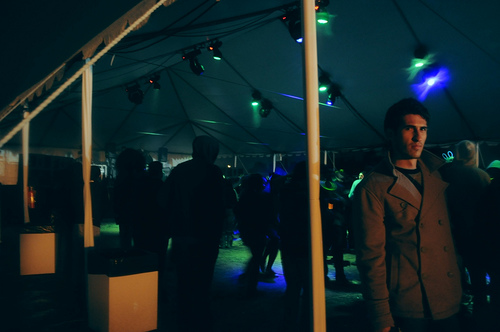

In [7]:
print(train_captions[2])
Image.open(img_name_vector[2])

In [8]:
print(len(train_captions))
print(len(img_name_vector))

30000
30000


In [9]:
def data_limiter(num,total_captions,all_img_name_vector):
   train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
   train_captions = train_captions[:num]
   img_name_vector = img_name_vector[:num]
   return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(29952,train_captions,img_name_vector)

In [10]:

def load_image(train_image_path):
   img = tf.io.read_file(train_image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, train_image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2024-12-16 07:19:19.927416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 07:19:19.927923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 07:19:19.928541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/nvidia/cudnn/lib:/home/manojale/.local/lib/python3.10/site-packages/nvidia/cuda_runtime/lib/libcudart.so.11.0:
2024-12-16 07:19:19.928808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.

In [11]:
import os
import tensorflow as tf
import numpy as np

# Ensure unique and valid paths
encode_train = sorted(set(img_name_vector))
# Correct extensions and ensure paths are valid
encode_train = [path.split('.')[0] + '.jpg' for path in encode_train if os.path.exists(path.split('.')[0] + '.jpg')]

# Define the load_image function
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # Adjust size based on your model
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Create TensorFlow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# Process and save features
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


In [12]:
# Add <start> and <end> tokens to each caption
train_captions = ['<start> ' + caption + ' <end>' for caption in train_captions]


In [13]:
top_k = 5000
# Fit tokenizer on the updated captions
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [14]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

In [15]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [16]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
def map_func(img_name, cap):
    try:
        # Attempt to load the file
        img_tensor = np.load(img_name.decode('utf-8') + '.npy')
        return img_tensor, cap
    except FileNotFoundError:
        # Return a placeholder tensor for missing files
        print(f"File not found: {img_name.decode('utf-8')}. Using placeholder.")
        return np.zeros((64, 2048), dtype=np.float32), cap  # Placeholder tensor


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
def get_angles(pos, i, d_model):
   angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
   return pos * angle_rates

def positional_encoding_1d(position, d_model):
   angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

   angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
   angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
   pos_encoding = angle_rads[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
   assert d_model % 2 == 0
   row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
   col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

   angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
   angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

   angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
   angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
   angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
   angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
   pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
   return tf.cast(pos_encoding, dtype=tf.float32)

In [18]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

   if mask is not None:
      scaled_attention_logits += (mask * -1e9) 

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)])



In [19]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention(d_model, num_heads)
      self.mha2 = MultiHeadAttention(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [21]:
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)

In [22]:
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

In [23]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

In [24]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [26]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [27]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [28]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask

In [29]:
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)   
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [30]:
for epoch in range(10):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5720 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.0022 Accuracy 0.0287
Epoch 1 Batch 100 Loss 7.4959 Accuracy 0.0370
Epoch 1 Batch 150 Loss 7.1415 Accuracy 0.0443
Epoch 1 Batch 200 Loss 6.8146 Accuracy 0.0499
Epoch 1 Batch 250 Loss 6.4997 Accuracy 0.0558
File not found: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/2258277193_586949ec62.jpg.1. Using placeholder.
File not found: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/2258277193_586949ec62.jpg.1. Using placeholder.
File not found: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/2258277193_586949ec62.jpg.1. Using placeholder.
File not found: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/2258277193_586949ec62.jpg.1. Using placeholder.
File not found: /home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/2258277193_586949ec6

In [31]:
transformer.save_weights('/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/checkpoints/transformer_weights')


In [43]:
os.listdir('/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/checkpoints/')

['transformer_weights.index',
 'checkpoint',
 'transformer_weights.data-00000-of-00001']

In [112]:
test_image_paths = image_paths[-500:]  # Use the last 500 images for testing
test_captions = []
test_img_name_vector = []

for image_path in test_image_paths:
    caption_list = annotations[image_path]
    test_captions.extend(caption_list)
    test_img_name_vector.extend([image_path] * len(caption_list))


In [113]:
test_img_name_vector = ['/home/manojale/Documents/Performance_Dataset/Untitled Folder/Data_new/Flickr8k_Dataset/'+i for i in test_img_name_vector ]

In [114]:
len(test_img_name_vector)
test_img_name_vector = test_img_name_vector[:500]
test_captions = test_captions[:500]

In [115]:
test_captions

['A man walking 3 dalmatians along a sunny street .',
 'A man walks a group of Dalmatians on the beach .',
 'A man walks three white dogs with spots down a street with palm trees .',
 'Man walking three dalmatians along a palm-tree lined street .',
 'This man with three dogs takes his route along the tree-lined street .',
 'A boy doing a handstand in a yellow shirt',
 'A boy is brake dancing as a crowd watches .',
 'A man is standing on his hands on a sidewalk while others watch .',
 'A man is standing on his hands with lots of people around him .',
 'A person doing a handstand in front of others .',
 'a dog trots through the grass .',
 'A fluffy white dog is outside .',
 'A white dog competing in an agility event .',
 'A white dog lifts its paw as it stands on the grass near striped poles .',
 'The small furry white dog is walking in the green grass .',
 'a tan dog jumping through the field with some barren trees in the background',
 'A tan dog runs through the brush .',
 'A white dog

A boy is brake dancing as a crowd watches .


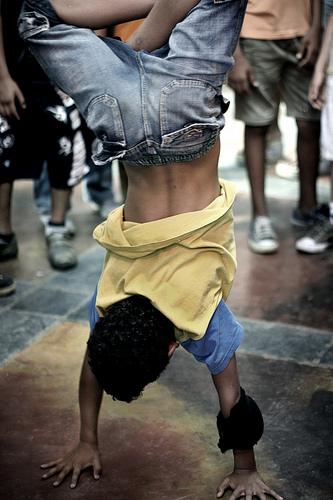

In [116]:
print(test_captions[6])
Image.open(test_img_name_vector[6])

In [117]:
len(test_captions)

500

In [118]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

# Initialize BLEU scores
bleu_1_scores = []
bleu_2_scores = []
bleu_3_scores = []
bleu_4_scores = []

# Evaluate each test image
for idx, image in tqdm(enumerate(test_img_name_vector), total=len(test_img_name_vector)):
    # Get real and predicted captions
    real_caption = test_captions[idx]
    predicted_caption, _, _ = evaluate(image)
    predicted_caption =' '.join(predicted_caption)

    # Tokenize captions for BLEU evaluation
    reference = [real_caption.split()]  # Real caption as list of tokens
    candidate = predicted_caption.split()  # Predicted caption as list of tokens
    bleu_1_scores.append(sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0)))
    bleu_2_scores.append(sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
    bleu_3_scores.append(sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
    bleu_4_scores.append(sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

# Average BLEU scores
avg_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
avg_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
avg_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
avg_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)

print(f"Average BLEU-1 score: {avg_bleu_1 * 100:.2f}")
print(f"Average BLEU-2 score: {avg_bleu_2 * 100:.2f}")
print(f"Average BLEU-3 score: {avg_bleu_3 * 100:.2f}")
print(f"Average BLEU-4 score: {avg_bleu_4 * 100:.2f}")


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [06:50<00:00,  1.22it/s]

Average BLEU-1 score: 18.22
Average BLEU-2 score: 7.34
Average BLEU-3 score: 2.32
Average BLEU-4 score: 0.64


In [53]:
real_caption


'A person doing a handstand in front of others .'

In [54]:
predicted_caption

'two little boys are playing with a toy in a parking lot'

In [48]:
real_caption = test_captions[idx]
real_caption

'The large brown dog with the red collar is in the grass .'

In [37]:
predicted_caption

['two',
 'children',
 'on',
 'a',
 'street',
 'with',
 'a',
 'dog',
 'on',
 'the',
 'street']

In [35]:
def evaluate(image):
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = tokenizer.word_index['<start>']
   end_token = tokenizer.word_index['<end>']
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      dec_mask = create_masks_decoder(output)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0), attention_weights
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0), attention_weights

In [59]:
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: a doberman biting a blue ball on a grassy surface
Predicted Caption: two dogs are running in the grass


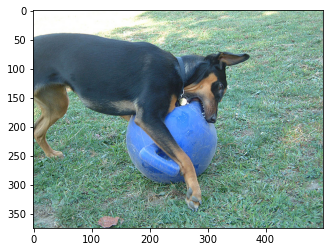

In [60]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 22.062422564614888
BLEU-2 score: 16.677623835883093
BLEU-3 score: 1.6434977345885395e-91
BLEU-4 score: 5.722633035689358e-153
Real Caption: a woman and girl pose together in a garden
Predicted Caption: two little girls are playing in a field


/home/manojale/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/manojale/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


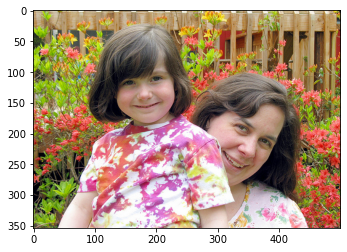

In [61]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 48.67504894196281
BLEU-2 score: 40.30676984898244
BLEU-3 score: 30.644460082517156
BLEU-4 score: 4.372204660033707e-76
Real Caption: a black dog holding an orange object in the water
Predicted Caption: a black dog is running through the water


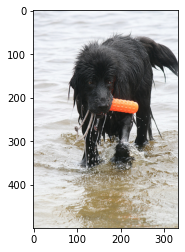

In [62]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 7.1428571428571415
BLEU-2 score: 3.986650812853149e-153
BLEU-3 score: 1.1602945388103906e-183
BLEU-4 score: 9.418382295637229e-230
Real Caption: a crowd of children and some are wearing green costumes
Predicted Caption: two people in a costume one holding a baby that has a red cup


/home/manojale/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


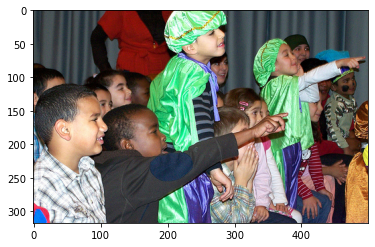

In [64]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
   if i=="<unk>":
      caption.remove(i)

for i in real_caption:
   if i=="<unk>":
      real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

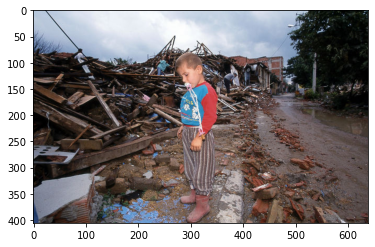

In [78]:



caption,result,attention_weights = evaluate("Example_3.jpg")


temp_image = np.array(Image.open("Example_3.jpg"))
plt.imshow(temp_image)

In [79]:
 print(' '.join(caption))

a boy in a red shirt is standing on a rock overlooking a stream


two women are looking at a book while one is holding a book cup


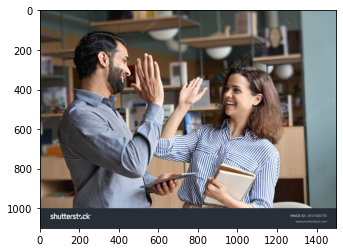

In [106]:



caption,result,attention_weights = evaluate("Example_1.jpg")
print(' '.join(caption))
temp_image = np.array(Image.open("Example_1.jpg"))
plt.imshow(temp_image)

two people are sitting in a room and one has a tattoo on his arm


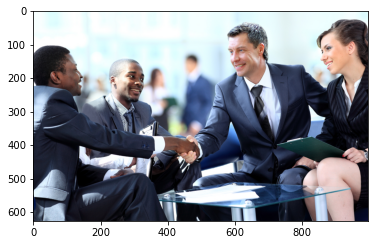

In [107]:



caption,result,attention_weights = evaluate("Example_2.jpg")
print(' '.join(caption))
temp_image = np.array(Image.open("Example_2.jpg"))
plt.imshow(temp_image)

a black and white dog is looking at a red ball


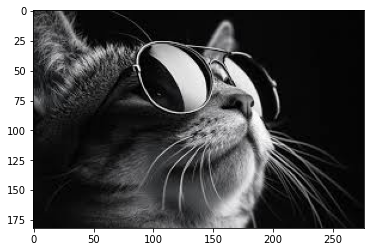

In [108]:



caption,result,attention_weights = evaluate("Cat_watching.jpeg")
print(' '.join(caption))
temp_image = np.array(Image.open("Cat_watching.jpeg"))
plt.imshow(temp_image)